In [1]:
%load_ext autotime

time: 0 ns (started: 2023-07-12 18:01:25 +07:00)


In [2]:
from fastai.vision.all import *

from fastkaggle import *

from sklearn.metrics import RocCurveDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np

set_seed(42)

time: 6.58 s (started: 2023-07-12 18:01:25 +07:00)


In [3]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

time: 0 ns (started: 2023-07-12 18:01:32 +07:00)


In [4]:
def ROC(y_onehot_test, y_score, dls, n_classes):
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    fig, ax = plt.subplots(figsize=(10, 10))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=7,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=7,
    )

    for class_id in zip(range(n_classes)):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {dls.vocab[class_id]}",
            ax=ax,
            linewidth=4,
        )
        

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate", fontsize=20)
    plt.ylabel("True Positive Rate", fontsize=20)
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass" , fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend().get_lines()[len(plt.legend().get_lines()) // 2].set_linewidth(20) 
    plt.legend().set_visible(False)
    plt.show()


def PRC(y_onehot_test, y_score, dls, n_classes):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_onehot_test.ravel(), y_score.ravel()
    )
    average_precision["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

    _, ax = plt.subplots(figsize=(10, 10))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {dls.vocab[i]}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    # labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    # Set the font size of the axis labels
    ax.set_xlabel('Recall', fontsize=20)
    ax.set_ylabel('Precision', fontsize=20)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    ax.legend(handles=handles, labels=labels, loc="best", fontsize=15)
    ax.set_title("Extension of Precision-Recall curve to multi-class", {'fontsize': 20})

    plt.show()



time: 0 ns (started: 2023-07-12 18:01:32 +07:00)


In [5]:
comp = '../../../../../paddy-diseases'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

time: 94 ms (started: 2023-07-12 18:01:32 +07:00)


In [6]:
dls = ImageDataLoaders.from_folder(path/"train", 
                                   valid_pct=0.25, 
                                   item_tfms=Resize(256), 
                                   batch_tfms=aug_transforms(   size=64, 
                                                                min_scale=0.75,
                                                                max_rotate=10., 
                                                                min_zoom=0.8, 
                                                                max_zoom=1.2, 
                                                            
                                                            ), 
                                   bs=32)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
time: 4.56 s (started: 2023-07-12 18:01:32 +07:00)


In [7]:
learner= load_learner(Path("../../../../../model/nvidia-t4/VGG16_bn_sparsity25_pruned.pkl"))

time: 12 s (started: 2023-07-12 18:01:36 +07:00)


In [8]:
tst_files = get_image_files(path/'test').sorted()
tst_dl = dls.test_dl(tst_files, with_labels=True,)


time: 531 ms (started: 2023-07-12 18:01:50 +07:00)


In [9]:
preds, _, idx = learner.get_preds(dl=tst_dl, with_decoded=True)
y_score = preds.numpy()

time: 1min 32s (started: 2023-07-12 18:01:51 +07:00)


In [10]:
y_onehot_test = (y_score == y_score.max(axis=1, keepdims=1)).astype(int)

time: 16 ms (started: 2023-07-12 18:03:23 +07:00)


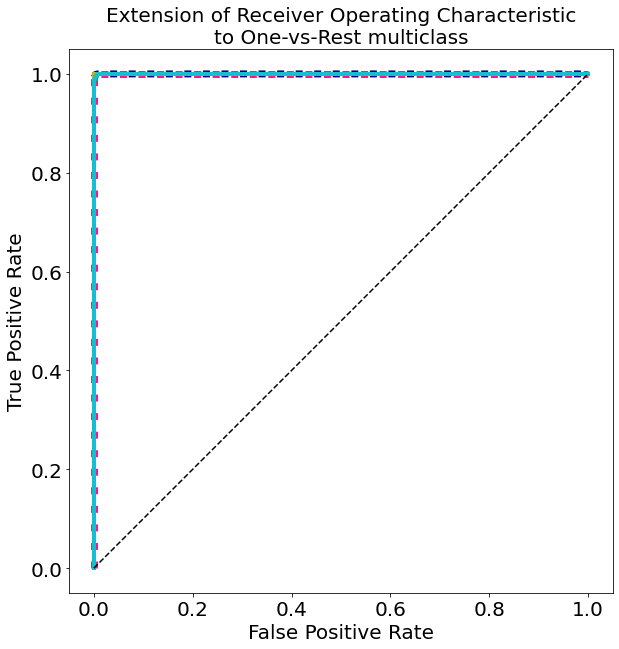

time: 453 ms (started: 2023-07-12 18:03:23 +07:00)


In [11]:
ROC(y_onehot_test, y_score, dls, 10)

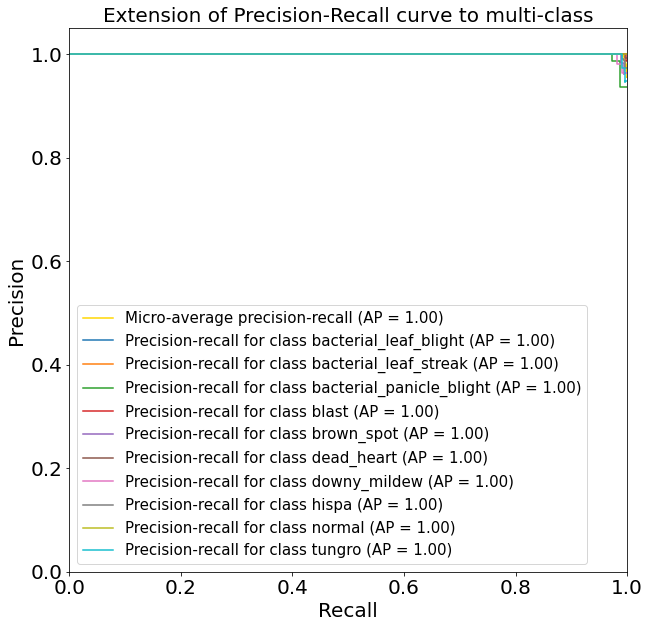

time: 438 ms (started: 2023-07-12 17:32:02 +07:00)


In [ ]:
PRC(y_onehot_test, y_score, dls, n_classes=10)

In [ ]:
interpret = ClassificationInterpretation.from_learner(learner, dl=tst_dl)

time: 1min 27s (started: 2023-05-24 18:53:10 +07:00)


In [ ]:
interpret.print_classification_report()

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.88      0.96      0.92        96
   bacterial_leaf_streak       0.86      0.97      0.91        76
bacterial_panicle_blight       0.85      0.93      0.89        68
                   blast       0.92      0.95      0.94       348
              brown_spot       0.95      0.89      0.92       193
              dead_heart       0.96      0.94      0.95       289
            downy_mildew       0.93      0.81      0.86       124
                   hispa       0.95      0.94      0.95       319
                  normal       0.94      0.96      0.95       353
                  tungro       0.93      0.92      0.93       218

                accuracy                           0.93      2084
               macro avg       0.92      0.93      0.92      2084
            weighted avg       0.93      0.93      0.93      2084

time: 1min 25s (started: 2023-05-24 18:54:37 +07:00)


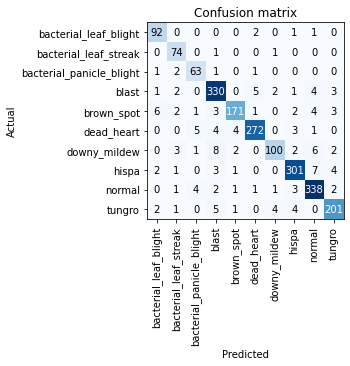

time: 1min 21s (started: 2023-05-24 18:56:03 +07:00)


In [ ]:
interpret.plot_confusion_matrix(figsize=(5,5))